# Nettverksanalyse i sgis
https://github.com/statisticsnorway/ssb-sgis

Notebook-en kan kjøres i dapla hvis man har tilgang til bøtta 'kart'.

Eller åpnes her: https://nbviewer.org/github/statisticsnorway/intro_til_geopandas/blob/main/brukerforum_20_04_2022/nettverksanalyse.ipynb

In [1]:
import numpy as np
import sgis as sg

## Hente data

Henter bygningspunkter i Oslo.

In [2]:
aar = 2022
kommnr = "0301"

bygningspunktsti = f"ssb-prod-kart-data-delt/kartdata_analyse/klargjorte-data/{aar}/SMAT_bygg_punkt_p{aar}_v1.parquet"

bygg = sg.read_geopandas(
    bygningspunktsti,
    filters=[f"KOMMUNENR = {kommnr}".split()],
    columns=["geometry"]
)

Henter vegdata i Oslo for 2022 med relevante kolonner: retning og kjøretid.

In [3]:
kartdata = "ssb-prod-kart-data-delt/kartdata_analyse/klargjorte-data"

veger_oslo = (
    sg.read_geopandas(
        f"{kartdata}/2022/NVDB_ruteplan_nettverk_p20220703_v1.parquet",
        filters=[f"KOMMUNENR = {kommnr}".split()],
        columns=["oneway", "drivetime_fw", "drivetime_bw", "geometry"]
    )
    .sort_values("oneway")
    .reset_index(drop=True)
)

veger_oslo

oneway  drivetime_fw  drivetime_bw  \
0          B      0.216611      0.216611   
1          B      0.064631      0.064631   
2          B      0.023387      0.023387   
3          B      0.174470      0.174470   
4          B      0.085934      0.085934   
...      ...           ...           ...   
93390     TF     -1.000000      0.003683   
93391     TF     -1.000000      0.031986   
93392     TF     -1.000000      0.010607   
93393     TF     -1.000000      0.004257   
93394     TF     -1.000000      0.128560   

                                                geometry  
0      MULTILINESTRING Z ((258028.440 6674249.890 413...  
1      MULTILINESTRING Z ((263329.703 6652880.398 88....  
2      MULTILINESTRING Z ((270274.700 6651212.900 154...  
3      MULTILINESTRING Z ((267240.000 6644124.500 133...  
4      MULTILINESTRING Z ((273365.300 6652133.100 174...  
...                                                  ...  
93390  MULTILINESTRING Z ((263871.009 6648498.376 29....  
93391  MULTILINESTRING Z ((267727.200 6649124.300 155...  
93392  MULTILINESTRING Z ((263871.400 6648500.800 29....  
93393  MULTILINESTRING Z ((256561.560 6651007.630 63....  
93394  MULTILINESTRING Z ((262522.672 6651527.844 52....  

[93395 rows x 4 columns]

## Gjør klar til nettverksanalyse

Starter med å definere noen regler for analysene.

Jeg vil beregne kjøretid med bil. Setter derfor vekt-kolonnen til "minutes" og directed til True (som betyr at man bare kan bevege seg i én retning langs vegene).

In [4]:
regler = sg.NetworkAnalysisRules(
    directed=True,
    weight="minutes",
    search_tolerance=500, # meter
)
regler

NetworkAnalysisRules(directed=True, weight='minutes', search_tolerance=500, search_factor=0, split_lines=False, nodedist_multiplier=None, nodedist_kmh=None)

For å få et vegnett der alle veger går i riktig retning, må man snu vegene som går i motsatt/begge retning(er).

In [5]:
antall_per_retning = veger_oslo.oneway.value_counts().to_frame()

antall_per_retning["hva_må_gjøres"] = {"B": "Duplisere og snu duplikatene", "TF": "Snu", "FT": "Ingenting"}

antall_per_retning

oneway                 hva_må_gjøres
B    82230  Duplisere og snu duplikatene
FT    7353                     Ingenting
TF    3812                           Snu

Og man må lage en felles minutt-kolonne av kjøretid-kolonnene.

In [6]:
veger_oslo[["oneway", "drivetime_fw", "drivetime_bw"]]

oneway  drivetime_fw  drivetime_bw
0          B      0.216611      0.216611
1          B      0.064631      0.064631
2          B      0.023387      0.023387
3          B      0.174470      0.174470
4          B      0.085934      0.085934
...      ...           ...           ...
93390     TF     -1.000000      0.003683
93391     TF     -1.000000      0.031986
93392     TF     -1.000000      0.010607
93393     TF     -1.000000      0.004257
93394     TF     -1.000000      0.128560

[93395 rows x 3 columns]

Dette kan gjøres sånn her:

In [7]:
veger_med_retning = sg.make_directed_network_norway(veger_oslo)
veger_med_retning

oneway   minutes                                           geometry
0           B  0.216611  MULTILINESTRING Z ((258028.440 6674249.890 413...
1           B  0.064631  MULTILINESTRING Z ((263329.703 6652880.398 88....
2           B  0.023387  MULTILINESTRING Z ((270274.700 6651212.900 154...
3           B  0.174470  MULTILINESTRING Z ((267240.000 6644124.500 133...
4           B  0.085934  MULTILINESTRING Z ((273365.300 6652133.100 174...
...       ...       ...                                                ...
175620     TF  0.003683  MULTILINESTRING Z ((263871.400 6648500.800 29....
175621     TF  0.031986  MULTILINESTRING Z ((267749.000 6649137.700 156...
175622     TF  0.010607  MULTILINESTRING Z ((263874.800 6648507.000 29....
175623     TF  0.004257  MULTILINESTRING Z ((256560.200 6651010.200 63....
175624     TF  0.128560  MULTILINESTRING Z ((262543.865 6651593.052 54....

[175541 rows x 3 columns]

Eller en mer generell variant:

In [8]:
veger_med_retning = sg.make_directed_network(
    veger_oslo,
    direction_col="oneway",
    direction_vals_bft=("B", "FT", "TF"),
    minute_cols=("drivetime_fw", "drivetime_bw"),
)

veger_med_retning

oneway   minutes                                           geometry
0           B  0.216611  MULTILINESTRING Z ((258028.440 6674249.890 413...
1           B  0.064631  MULTILINESTRING Z ((263329.703 6652880.398 88....
2           B  0.023387  MULTILINESTRING Z ((270274.700 6651212.900 154...
3           B  0.174470  MULTILINESTRING Z ((267240.000 6644124.500 133...
4           B  0.085934  MULTILINESTRING Z ((273365.300 6652133.100 174...
...       ...       ...                                                ...
175620     TF  0.003683  MULTILINESTRING Z ((263871.400 6648500.800 29....
175621     TF  0.031986  MULTILINESTRING Z ((267749.000 6649137.700 156...
175622     TF  0.010607  MULTILINESTRING Z ((263874.800 6648507.000 29....
175623     TF  0.004257  MULTILINESTRING Z ((256560.200 6651010.200 63....
175624     TF  0.128560  MULTILINESTRING Z ((262543.865 6651593.052 54....

[175541 rows x 3 columns]

In [9]:
print("Kilometer før:", veger_oslo.length.sum() / 1000)
print("Kilometer nå:", veger_med_retning.length.sum() / 1000)

Kilometer før: 3851.4819685472407
Kilometer nå: 7248.592623912765


In [10]:
veger_med_retning.minutes

0         0.216611
1         0.064631
2         0.023387
3         0.174470
4         0.085934
            ...   
175620    0.003683
175621    0.031986
175622    0.010607
175623    0.004257
175624    0.128560
Name: minutes, Length: 175541, dtype: float64

Man bør også fjerne isolerte nettverksøyer. Dette er gjerne veger bak bommer (innkjørsler, inni borettslag).

Sånn her kan man finne og fjerne nettverksøyene:

In [11]:
veger_ned_tilknytning = sg.get_connected_components(veger_med_retning).query("connected == 1")
veger_ned_tilknytning

oneway   minutes                                           geometry  \
1           B  0.064631  LINESTRING Z (263329.703 6652880.398 88.022, 2...   
3           B  0.174470  LINESTRING Z (267240.000 6644124.500 133.461, ...   
4           B  0.085934  LINESTRING Z (273365.300 6652133.100 174.571, ...   
5           B  0.119831  LINESTRING Z (273398.500 6651934.000 163.171, ...   
6           B  0.050873  LINESTRING Z (263319.400 6652894.300 87.962, 2...   
...       ...       ...                                                ...   
175620     TF  0.003683  LINESTRING Z (263871.400 6648500.800 29.259, 2...   
175621     TF  0.031986  LINESTRING Z (267749.000 6649137.700 156.064, ...   
175622     TF  0.010607  LINESTRING Z (263874.800 6648507.000 29.759, 2...   
175623     TF  0.004257  LINESTRING Z (256560.200 6651010.200 63.654, 2...   
175624     TF  0.128560  LINESTRING Z (262543.865 6651593.052 54.090, 2...   

        connected  
1             1.0  
3             1.0  
4             1.0  
5             1.0  
6             1.0  
...           ...  
175620        1.0  
175621        1.0  
175622        1.0  
175623        1.0  
175624        1.0  

[160137 rows x 4 columns]

In [12]:
print("Kilometer før:", veger_med_retning.length.sum() / 1000)
print("Kilometer nå:", veger_ned_tilknytning.length.sum() / 1000)

Kilometer før: 7248.592623912765
Kilometer nå: 6364.053626251761


In [13]:
sg.samplemap(veger_med_retning, veger_ned_tilknytning)

Nå er vegene klare for nettverksanalyse:

In [14]:
nwa = sg.NetworkAnalysis(network=veger_ned_tilknytning, rules=regler)
nwa

NetworkAnalysis(
    network=Network(6364 km, percent_bidirectional=87),
    rules=NetworkAnalysisRules(weight=minutes, directed=True, search_tolerance=500, search_factor=0, split_lines=False, ...),
    log=True, detailed_log=False,
)

### Først en liten test av retning
La oss teste at retningen lages riktig.

Sjekker at tur-retur Vippetangen-Ryen går i riktige tunnelløp.

In [15]:
vippetangen = sg.to_gdf([10.741527, 59.9040595], crs=4326).to_crs(veger_oslo.crs)
ryen = sg.to_gdf([10.8047522, 59.8949826], crs=4326).to_crs(veger_oslo.crs)

OBS: Å beregne én rute av gangen går mye treigere enn å beregne mange samtidig.

In [16]:
ryen_til_vippa = nwa.get_route(ryen, vippetangen)
vippa_til_ryen = nwa.get_route(vippetangen, ryen)
sg.explore(ryen_til_vippa, vippa_til_ryen)

### Reisetider: OD Cost Matrix

Lager 1000 start- og sluttpunkter.

In [17]:
origins = bygg.sample(1000)
origins.index = np.arange(0, 1000)
origins

geometry
0    POINT (260061.000 6654458.000)
1    POINT (257979.000 6654430.000)
2    POINT (264672.000 6647798.000)
3    POINT (261428.000 6650911.000)
4    POINT (257726.000 6655536.000)
..                              ...
995  POINT (266568.000 6651660.000)
996  POINT (265935.000 6651336.000)
997  POINT (265431.000 6654625.000)
998  POINT (267272.000 6646560.000)
999  POINT (273266.000 6653232.000)

[1000 rows x 1 columns]

In [18]:
destinations = bygg.sample(1000)
destinations.index = np.arange(1000, 2000)
destinations

geometry
1000  POINT (258461.000 6648507.000)
1001  POINT (259694.000 6650570.000)
1002  POINT (264073.000 6647469.000)
1003  POINT (264782.000 6643874.000)
1004  POINT (264253.000 6644561.000)
...                              ...
1995  POINT (262974.000 6657607.000)
1996  POINT (270183.000 6654364.000)
1997  POINT (264278.000 6643682.000)
1998  POINT (264663.000 6643370.000)
1999  POINT (266527.000 6639331.000)

[1000 rows x 1 columns]

Og beregner reisetid mellom dem:

In [19]:
od = nwa.od_cost_matrix(
    origins,
    destinations,
)

od

origin  destination    minutes
0            0         1000  17.112031
1            0         1001  11.616663
2            0         1002  19.542664
3            0         1003  23.095330
4            0         1004  22.399694
...        ...          ...        ...
999995     999         1995  21.713722
999996     999         1996   8.815491
999997     999         1997  23.102898
999998     999         1998  22.205892
999999     999         1999  26.235442

[1000000 rows x 3 columns]

Sjekk hvor mange prosent som mangler:

In [20]:
od.minutes.isna().mean() * 100

2.6824

La oss undersøke hvilke punkter som har mye manglende data. 

In [21]:
antall_som_ikke_mangler = od.groupby("origin", dropna=False).minutes.count()
origins["n_missing"] = len(origins) - antall_som_ikke_mangler
origins

geometry  n_missing
0    POINT (260061.000 6654458.000)         11
1    POINT (257979.000 6654430.000)         11
2    POINT (264672.000 6647798.000)         11
3    POINT (261428.000 6650911.000)         11
4    POINT (257726.000 6655536.000)         11
..                              ...        ...
995  POINT (266568.000 6651660.000)         11
996  POINT (265935.000 6651336.000)         11
997  POINT (265431.000 6654625.000)         11
998  POINT (267272.000 6646560.000)         11
999  POINT (273266.000 6653232.000)         11

[1000 rows x 2 columns]

In [22]:
# gjør kolonnen til tekst for å kunne huke av/på verdiene i explore
origins["n_missing_cat"] = origins.n_missing.astype(str)
sg.explore(origins, column="n_missing_cat")

Med lines=True får man rette linjer, så man lettere kan undersøke resultatene.

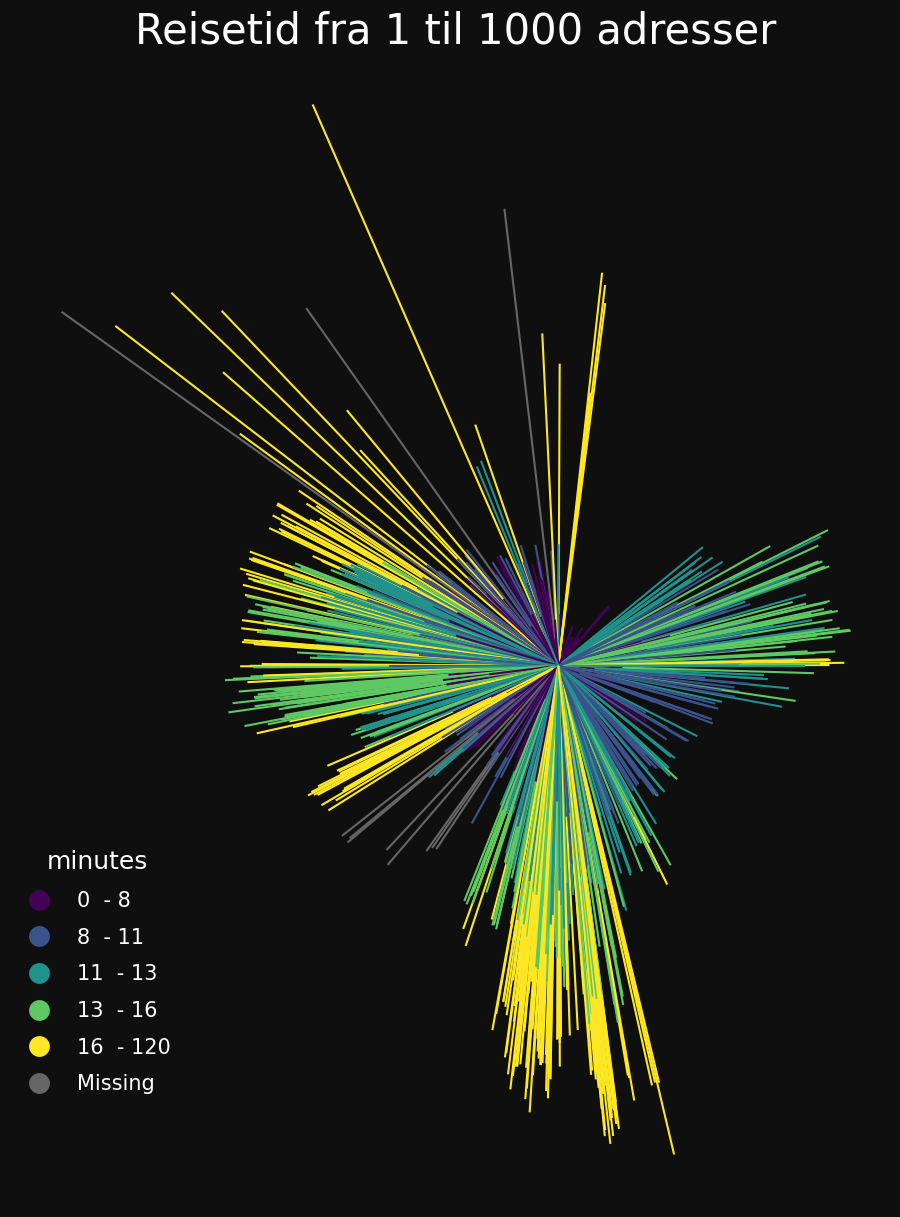

In [23]:
od = nwa.od_cost_matrix(
    origins.sample(1),
    destinations,
    lines=True
)

m = sg.ThematicMap(od, column="minutes", size=15)
m.black = True
m.title = "Reisetid fra 1 til 1000 adresser"
m.scheme = "quantiles"
m.plot()

Sjekke loggen:

In [24]:
nwa.log

endtime  minutes_elapsed          method  origins_count  \
0 2023-04-19 10:03:02              0.1       get_route              1   
1 2023-04-19 10:03:07              0.1       get_route              1   
2 2023-04-19 10:03:36              0.5  od_cost_matrix           1000   
3 2023-04-19 10:03:43              0.1  od_cost_matrix              1   

   destinations_count  percent_missing  cost_mean  percent_bidirectional  
0                   1           0.0000   6.354152                     87  
1                   1           0.0000   5.357292                     87  
2                1000           2.6824  15.744242                     87  
3                1000           1.1000  12.342858                     87